In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import make_blobs, load_iris, make_circles, load_breast_cancer
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelBinarizer
import xgboost as xgb
import lightgbm as lgbm

In [4]:
class SVMClassifier(torch.nn.Module):
    def __init__(
        self, kernel="linear", lam=0.01, C=None, gamma=0.1, degree=3, n_iters=1000
    ):
        super(SVMClassifier, self).__init__()
        self.bias = 0.0
        self.lam = lam
        self.C = C
        self.n_iters = n_iters
        self.gamma = gamma
        self.degree = degree
        self.kernel_name = kernel
        self.kernel = getattr(self, f"_{kernel}")

    def get_params(self, deep=True):
        return {
            "kernel": self.kernel_name,
            "lam": self.lam,
            "C": self.C,
            "gamma": self.gamma,
            "degree": self.degree,
            "n_iters": self.n_iters,
        }

    def set_params(self, **params):
        for key, value in params.items():
            if key == "kernel":
                self.kernel_name = value
                self.kernel = getattr(self, f"_{value}")
            else:
                setattr(self, key, value)
        return self

    def _preprocess_labels(self, y):
        y = torch.tensor(y, dtype=torch.float32)
        y_ = torch.where(y <= 0, -1, 1)
        return y_.float()

    def _linear(self, X1, X2):
        return X1 @ X2.T

    def _polynomial(self, X1, X2):
        return (X1 @ X2.T + 1) ** self.degree

    def _rbf(self, X1, X2):
        dist = torch.cdist(X1, X2, p=2) ** 2
        return torch.exp(-self.gamma * dist)

    def _margin(self, X):
        K = self.kernel(X, self.sv_X)
        return K @ (self.sv_alpha * self.sv_y)

    def _decision_function(self, X):
        return self._margin(X) + self.bias

    def fit(self, X, y):
        y = self._preprocess_labels(y)
        X = torch.tensor(X, dtype=torch.float32)

        n_samples, n_features = X.shape
        alpha = torch.zeros(n_samples, dtype=torch.float32, requires_grad=True)
        K = self.kernel(X, X)

        optimizer = torch.optim.SGD([alpha], lr=0.01)
        if self.C is None:
            self.C = 1 / (2 * self.lam * n_samples)

        for _ in range(self.n_iters):
            optimizer.zero_grad()
            loss = -torch.sum(alpha) + 0.5 * torch.sum(
                (alpha * y)[:, None] * (alpha * y)[None, :] * K
            )
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                alpha.clamp_(0, self.C)
                total = torch.dot(alpha, y)
                if torch.abs(total) > 1e-6:
                    correction = total / y.square().sum()
                    alpha -= correction * y
                    alpha.clamp_(0, self.C)

        self.alpha = alpha.detach()
        sv_mask = self.alpha > 1e-6
        self.sv_X = X[sv_mask]
        self.sv_y = y[sv_mask]
        self.sv_alpha = self.alpha[sv_mask]
        self.bias = torch.mean(self.sv_y - self._margin(self.sv_X))

        free_mask = (self.sv_alpha > 1e-6) & (self.sv_alpha < self.C - 1e-6)
        if torch.any(free_mask):
            margin_vals = self.sv_y[free_mask] - self._margin(self.sv_X[free_mask])
        else:
            margin_vals = self.sv_y - self._margin(self.sv_X)
        self.bias = torch.mean(margin_vals)

        K_sv = self.kernel(self.sv_X, self.sv_X)
        w_norm_sq = torch.sum(
            self.sv_alpha[:, None]
            * self.sv_alpha[None, :]
            * self.sv_y[:, None]
            * self.sv_y[None, :]
            * K_sv
        )
        self.margin_width = 1.0 / torch.sqrt(w_norm_sq + 1e-12)

    def predict(self, X):
        decision = self._decision_function(torch.tensor(X, dtype=torch.float32))
        return torch.sign(decision)

    def score(self, X, y):
        y = self._preprocess_labels(y)
        y_pred = self.predict(X)
        return (y == y_pred).sum() / y.shape[0]

    def plot(self, X_train, y_train, X_test, y_test):
        xx, yy = np.meshgrid(
            np.linspace(X_train[:, 0].min() - 1, X_train[:, 0].max() + 1, 200),
            np.linspace(X_train[:, 1].min() - 1, X_train[:, 1].max() + 1, 200),
        )

        grid = np.c_[xx.ravel(), yy.ravel()]
        zz = (
            self._decision_function(torch.tensor(grid, dtype=torch.float32))
            .reshape(xx.shape)
            .detach()
            .cpu()
            .numpy()
        )

        plt.contourf(xx, yy, zz, levels=50, cmap="coolwarm", alpha=0.3)
        plt.contour(
            xx,
            yy,
            zz,
            levels=[0],
            colors="k",
        )
        plt.contour(
            xx,
            yy,
            zz,
            levels=[-self.margin_width.item(), self.margin_width.item()],
            colors="black",
            linestyles="dashed",
            linewidths=0.7,
        )

        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)
        plt.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=self.predict(X_test),
            s=30,
            cmap=plt.cm.Paired,
            marker="x",
            label="Predicted",
        )
        plt.title(f"SVM decision boundary ({self.kernel_name} kernel)")
        plt.legend()

In [5]:
X, y = make_blobs(n_samples=200, centers=2, random_state=6)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [6]:
svm_lin = SVMClassifier(C=0.01)
svm_lin.fit(X_train, y_train)

svm_rbf = SVMClassifier(kernel="rbf")
svm_rbf.fit(X_train, y_train)

In [7]:
score = svm_lin.score(X_test, y_test)
print(f"SVM Test score: {score * 100:.2f}%")

SVM Test score: 100.00%


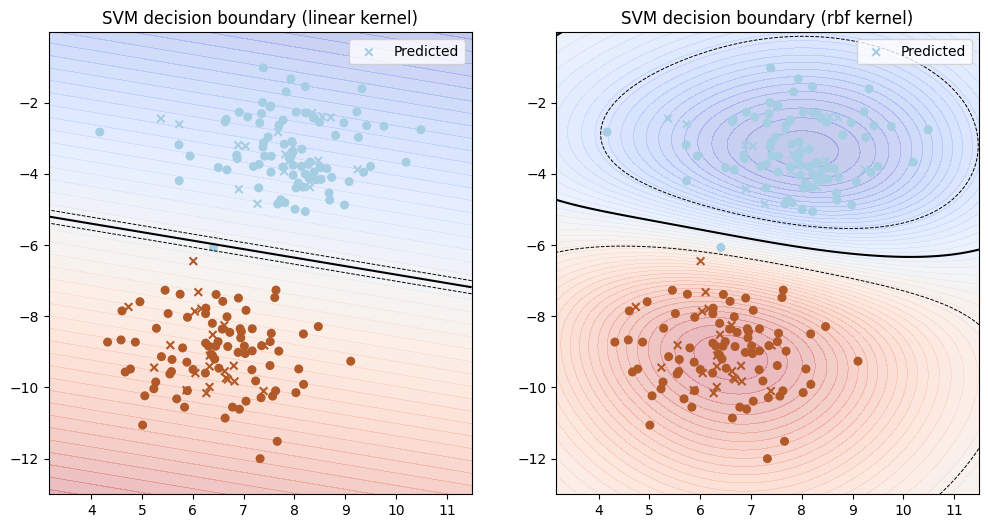

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
svm_lin.plot(X_train, y_train, X_test, y_test)
plt.subplot(1, 2, 2)
svm_rbf.plot(X_train, y_train, X_test, y_test)

In [9]:
X, y = make_circles(200, factor=0.2, random_state=42, noise=0.1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [10]:
svm_rbf = SVMClassifier(kernel="rbf", gamma=0.2)

svm_lin.fit(X_train, y_train)
svm_rbf.fit(X_train, y_train)

In [11]:
print("Linear:", svm_lin.score(X_test, y_test))
print("RBF:", svm_rbf.score(X_test, y_test))

Linear: tensor(0.4500)
RBF: tensor(1.)


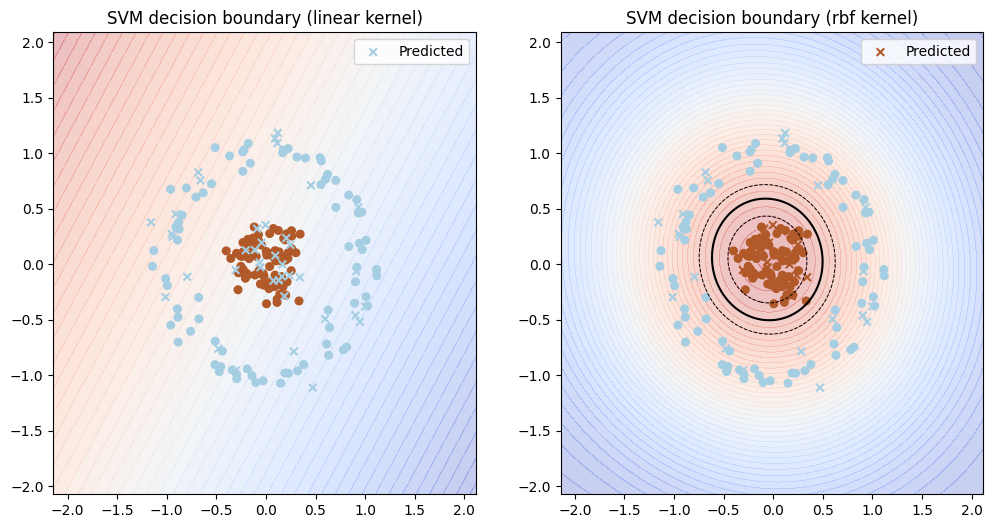

In [12]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
svm_lin.plot(X_train, y_train, X_test, y_test)
plt.subplot(1, 2, 2)
svm_rbf.plot(X_train, y_train, X_test, y_test)

In [32]:
optimal_svm = GridSearchCV(
    estimator=SVMClassifier(),
    param_grid={
        "C": np.linspace(0.01, 1, 20),
        "kernel": ["linear", "polynomial", "rbf"],
    },
)

In [57]:
bc_df = load_breast_cancer()


y = LabelBinarizer().fit_transform(bc_df.target).flatten()
X = bc_df.data

X_train, X_test, y_train, y_test = train_test_split(bc_df.data, y)

In [36]:
optimal_svm.fit(X_train, y_train)

GridSearchCV(estimator=SVMClassifier(),
             param_grid={'C': array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ]),
                         'kernel': ['linear', 'polynomial', 'rbf']})

In [42]:
print(optimal_svm.score(X_test, y_test))
print(optimal_svm.best_params_)

tensor(0.9021)
{'C': np.float64(0.01), 'kernel': 'linear'}


In [50]:
model_xgb = xgb.XGBClassifier()
model_lgbm = lgbm.LGBMClassifier()

In [51]:
%%timeit -n 100

model_xgb.fit(X_train, y_train)

27 ms ± 3.96 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [52]:
%%timeit -n 100

model_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 273, number of negative: 153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4266
[LightGBM] [Info] Number of data points in the train set: 426, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.640845 -> initscore=0.579034
[LightGBM] [Info] Start training from score 0.579034
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [54]:
print("XGBoost:", model_xgb.score(X_test, y_test))
print("LightGBM:", model_lgbm.score(X_test, y_test))

XGBoost: 0.9440559440559441
LightGBM: 0.9440559440559441


/home/felix/repo/ml-laby/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [59]:
N = 5

kf = KFold(n_splits=N)

score = 0

for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    model_xgb_kf = xgb.XGBClassifier()
    model_xgb_kf.fit(X[train_index], y[train_index])
    score += model_xgb_kf.score(X[test_index], y[test_index])

print("Mean score:", score / N)

Mean score: 0.9684055270920664
